In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# Dati estrapolati dal db remoto di Giuliano in data 19/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

df = pd.concat([df1, df2], ignore_index=True)

In [33]:
df

,tm,knt,ae,ae_cl,rv
0,2023-05-08 16:09:16.771572,1500,0.326013,0,"3.6620999999999997, 3.6620999999999997, 3.6620..."
1,2023-12-07 05:17:16.98583,1500,0.317388,0,"9.7656, 9.7656, 9.7656, 9.7656, 9.7656, 9.7656..."
2,2023-12-07 12:29:06.618496,1500,0.249031,0,"13.427699999999998, 14.648399999999999, 13.427..."
3,2023-12-08 01:46:33.934387,1500,0.339904,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."
4,2023-12-08 01:46:35.315528,1500,0.264804,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."
...,...,...,...,...,...
9927,2022-09-20 04:13:03.46475,1500,0.980339,2,"27.0027, 26.0026, 26.0026, 27.0027, 27.0027, 2..."
9928,2022-09-20 04:16:08.638387,1500,0.979374,2,"27.0027, 27.0027, 27.0027, 27.0027, 27.0027, 2..."
9929,2022-09-20 04:19:13.815312,1500,0.991370,2,"27.0027, 27.0027, 26.0026, 27.0027, 27.0027, 2..."
9930,2022-09-20 04:22:18.995324,1500,0.967481,2,"27.0027, 27.0027, 27.0027, 27.0027, 27.0027, 2..."


In [34]:
import numpy as np

In [49]:
dfTraining = pd.concat(
    [
        np.array_split(df[df.ae_cl == 0], 3)[0],
        np.array_split(df[df.ae_cl == 0], 3)[1],
        np.array_split(df[df.ae_cl == 1], 3)[0],
        np.array_split(df[df.ae_cl == 1], 3)[1],        
        np.array_split(df[df.ae_cl == 2], 3)[0],
        np.array_split(df[df.ae_cl == 2], 3)[1]
    ],
    ignore_index=True
)


dfTest = pd.concat(
    [
        np.array_split(df[df.ae_cl == 0], 3)[2],
        np.array_split(df[df.ae_cl == 1], 3)[2],
        np.array_split(df[df.ae_cl == 2], 3)[2]
    ],
    ignore_index=True
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


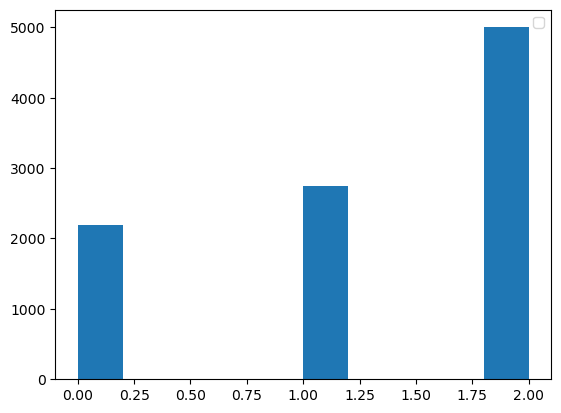

In [36]:
plt.hist([df['ae_cl']])
plt.legend()
plt.show()

In [37]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [38]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTraining['mn'] = dfTraining.select_dtypes(include='number').mean(axis=1)
dfTraining['ds'] = dfTraining.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [39]:
X = dfTraining.loc[:, 'rv1':'ds'].astype(float).values
y = dfTraining['ae_cl']

In [40]:
# Preprocessing steps
# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [41]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
#lp = MLPRegressor()

In [13]:
# Define the parameter grid to search
'''param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 300]
}'''


"param_grid = {\n    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],\n    'activation': ['relu', 'tanh'],\n    'alpha': [0.0001, 0.001, 0.01],\n    'learning_rate': ['constant', 'invscaling', 'adaptive'],\n    'max_iter': [100, 200, 300]\n}"

In [14]:
# Use GridSearchCV to find the best combination of hyperparameters
'''grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)'''

"grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)\ngrid_search.fit(X_train, y_train)"

In [15]:
# Get the best parameters
#best_params = grid_search.best_params_

In [42]:
#result of gridSearch
params = {'activation': 'tanh',
 'alpha': 0.01,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'invscaling',
 'max_iter': 100}

In [43]:
# Train the model with the best parameters
best_model = MLPRegressor(**params)
best_model.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 50, 25),
             learning_rate='invscaling', max_iter=100)

In [44]:
# Make predictions on the test set
predictions = best_model.predict(X_test)

In [45]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

#print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error on the test set: 0.05814929034976029
R-squared on the test set: 0.9948547215760457


In [46]:
predictionsRound = np.around(predictions, decimals=0)

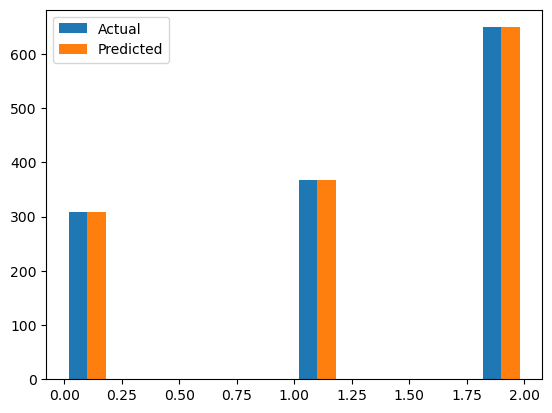

In [47]:
plt.hist([y_test, predictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

In [50]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTest['mn'] = dfTest.select_dtypes(include='number').mean(axis=1)
dfTest['ds'] = dfTest.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500,mn,ds
0,2023-11-27 18:19:18.865912,1500,0.314221,0,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,...,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,500.104740,707.032730
1,2023-11-27 18:20:15.4063,1500,0.215168,0,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,...,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,500.071723,707.056071
2,2023-11-27 18:22:22.580123,1500,0.146769,0,1594.1594,1594.1594,1594.1594,1594.1594,1594.1594,1594.1594,...,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,500.048923,707.072190
3,2023-11-27 18:23:20.619932,1500,0.372232,0,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,...,1592.1592,1592.1592,1592.1592,1592.1592,1591.1591,1592.1592,1591.1591,1592.1592,500.124077,707.019062
4,2023-11-27 18:25:27.777907,1500,0.326013,0,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,...,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,500.108671,707.029952


In [51]:
new_data = dfTest.loc[:, 'rv1':'ds'].astype(float).values
target_new_data = dfTest['ae_cl']

In [52]:
# Apply the same preprocessing steps to the new data
new_data_imputed = imputer.transform(new_data)
new_data_scaled = scaler.transform(new_data_imputed)

In [53]:
# Use the trained model to make predictions on the new data
new_data_predictions = best_model.predict(new_data_scaled)

In [54]:
newPredictionsRound = np.around(new_data_predictions, decimals=0)

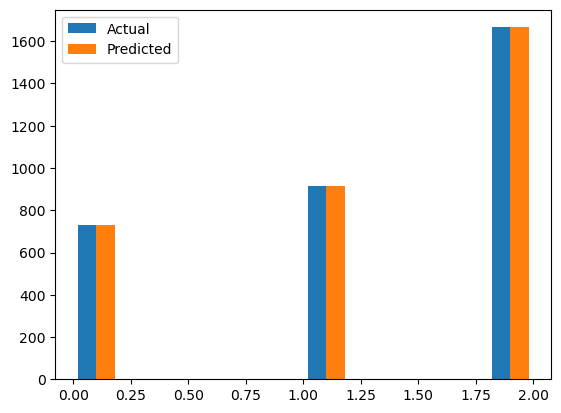

In [55]:
plt.hist([target_new_data, newPredictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()